# Graph
[Draw] graphs using the [ForceAtlas2] energy model. Graphs can be [directed] and/or [weighted].

For a larger example, see the [7 Degrees of Martin Brundle].


[Draw]: https://en.wikipedia.org/wiki/Graph_drawing
[ForceAtlas2]: https://doi.org/10.1371/journal.pone.0098679
[directed]: https://en.wikipedia.org/wiki/Directed_graph
[weighted]: https://en.wikipedia.org/wiki/Glossary_of_graph_theory#weighted_graph
[7 Degrees of Martin Brundle]: https://brundling.neocities.org/

In [1]:
from graph import GraphFrame

## build a GraphFrame
GraphFrame can import and export several different graph data structures.

Internally, each graph is stored as a DataFrame with 3 columns: `source`, `target`, `weight`.

For example, if the node named `a` points to the node named `b` with weight 0.1, that information is stored as the row `('a', 'b', 0.1)`.

[directed graph]: https://en.wikipedia.org/wiki/Directed_graph

**from triples:** Each link is a (source, target, weight) tuple.

In [2]:
triples = (
    ('alice', 'bob', 2),
    ('alice', 'carol', 1),
    ('bob', 'alice', 1),
    ('bob', 'carol', 1),
    ('carol', 'alice', 1),
)
graph = GraphFrame(triples)
graph

GraphFrame with 5 links
  source target  weight
0  alice    bob       2
1  alice  carol       1
2    bob  alice       1
3    bob  carol       1
4  carol  alice       1

**from pairs:** Each link is a (source, target) tuple.

Links are weighted by how often they appear.

In [3]:
pairs = (
    ('alice', 'bob'),
    ('alice', 'bob'),
    ('alice', 'carol'),
    ('bob', 'alice'),
    ('bob', 'carol'),
    ('carol', 'alice'),
)
GraphFrame(pairs)

GraphFrame with 5 links
  source target  weight
0  alice    bob       2
1  alice  carol       1
2    bob  alice       1
3    bob  carol       1
4  carol  alice       1

**from sources:** Each node is a key. Each value is the list of nodes which point to that key.

In [4]:
sources = dict()
sources['alice'] = ['bob', 'carol']
sources['bob'] = ['alice', 'alice']
sources['carol'] = ['alice','bob']
GraphFrame.from_sources(sources)

GraphFrame with 5 links
  source target  weight
0  alice    bob       2
1  alice  carol       1
2    bob  alice       1
3    bob  carol       1
4  carol  alice       1

**from targets:** Each node is a key. Each value is a list of nodes to which that key points.

In [5]:
targets = dict()
targets['alice'] = ['bob', 'bob', 'carol']
targets['bob'] = ['alice', 'carol']
targets['carol'] = ['alice']
GraphFrame.from_targets(targets)

GraphFrame with 5 links
  source target  weight
0  alice    bob       2
1  alice  carol       1
2    bob  alice       1
3    bob  carol       1
4  carol  alice       1

**by [transposing] a GraphFrame**

[transposing]: https://en.wikipedia.org/wiki/Transpose_graph

In [6]:
graph.flipped()

GraphFrame with 5 links
  source target  weight
0  alice    bob       1
1  alice  carol       1
2    bob  alice       2
3  carol  alice       1
4  carol    bob       1

## export graph attributes

In [7]:
# Access the internal DataFrame directly
graph.links

,source,target,weight
0,alice,bob,2
1,alice,carol,1
2,bob,alice,1
3,bob,carol,1
4,carol,alice,1


In [8]:
# links as a SciPy sparse adjacency matrix
graph.matrix

<3x3 sparse matrix of type '<class 'numpy.int64'>'
	with 5 stored elements in Compressed Sparse Row format>

In [9]:
# links as a NumPy adjacency matrix
graph.matrix.toarray()

array([[0, 2, 1],
       [1, 0, 1],
       [1, 0, 0]])

In [10]:
# list of all distinct nodes
graph.nodes

['alice', 'bob', 'carol']

In [11]:
# Series of weights for each distinct (source, target)
graph.weights

source  target
alice   bob       2
        carol     1
bob     alice     1
        carol     1
carol   alice     1
Name: weight, dtype: int64

## iterate over a graph

In [12]:
# iterate over links (as namedtuples)
for link in graph:
    print(link)

Link(source='alice', target='bob', weight=2)
Link(source='alice', target='carol', weight=1)
Link(source='bob', target='alice', weight=1)
Link(source='bob', target='carol', weight=1)
Link(source='carol', target='alice', weight=1)


In [13]:
# iterate over links (as components)
for s,t,w in graph:
    print(f"{s} -> {t} : {w}")

alice -> bob : 2
alice -> carol : 1
bob -> alice : 1
bob -> carol : 1
carol -> alice : 1


In [14]:
# iterate over links without weights
for s,t in graph.pairs():
    print(f"{s} -> {t}")

alice -> bob
alice -> carol
bob -> alice
bob -> carol
carol -> alice


In [15]:
# map each source to a list of its targets
{x:y for x,y in graph.targets()}

{'alice': ['bob', 'carol'], 'bob': ['alice', 'carol'], 'carol': ['alice']}

In [16]:
# map each target to a list of its sources
{x:y for x,y in graph.sources()}

{'alice': ['bob', 'carol'], 'bob': ['alice'], 'carol': ['alice', 'bob']}

## calculate coordinates

In [17]:
graph.coords()

,x,y
alice,-0.204894,0.008630
bob,0.206490,-0.318065
carol,0.284892,0.462732


## plot coordinates

<Axes: xlabel='x', ylabel='y'>

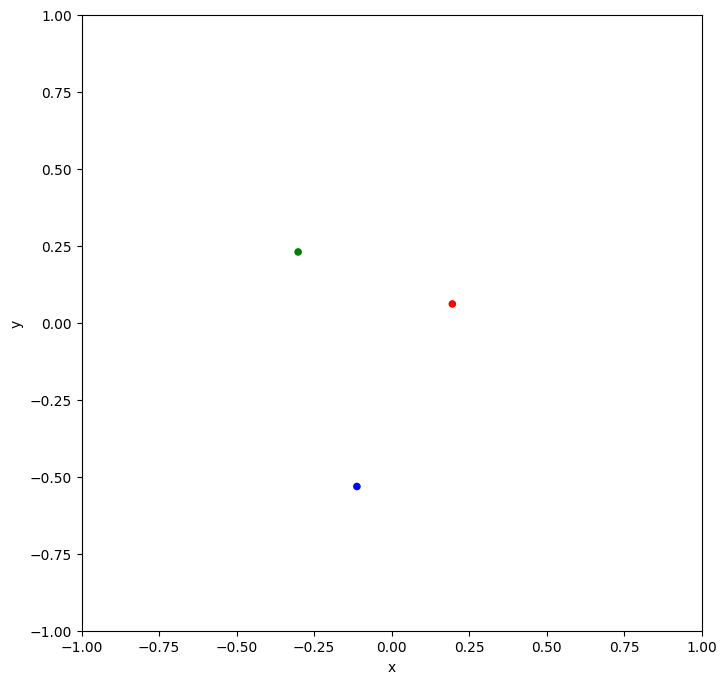

In [18]:
graph.plot(color=list('rgb'))

## show timesteps

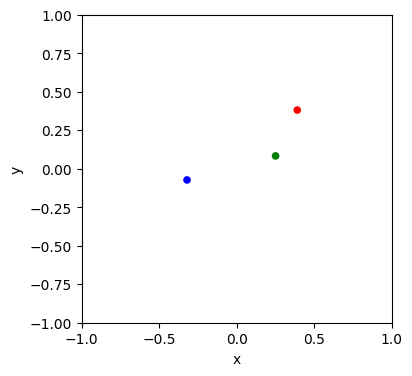

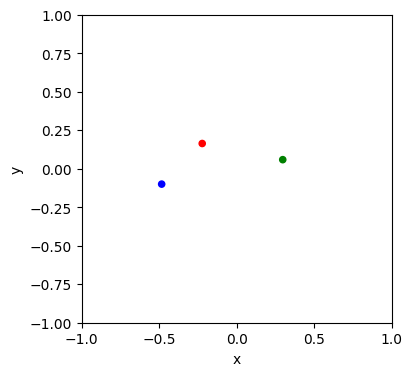

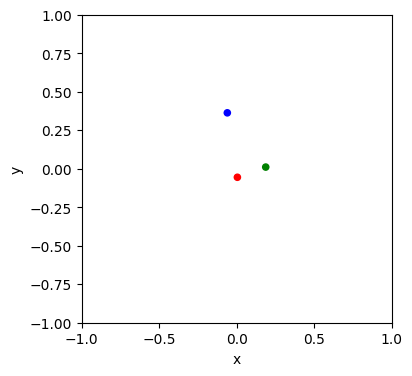

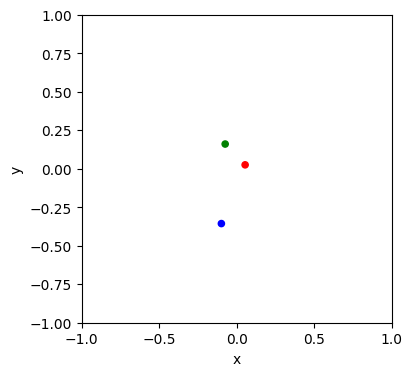

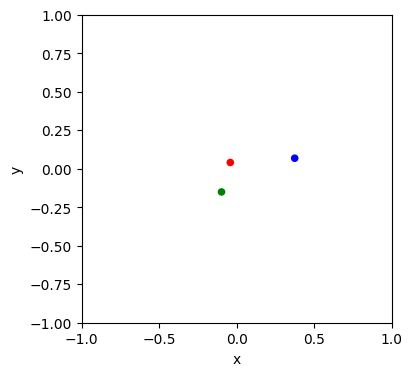

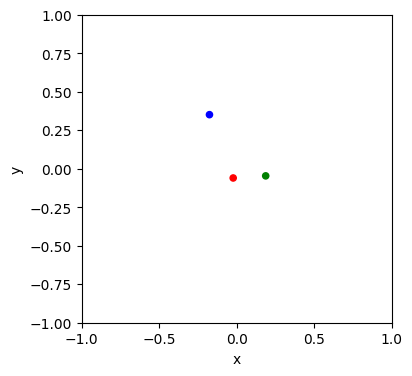

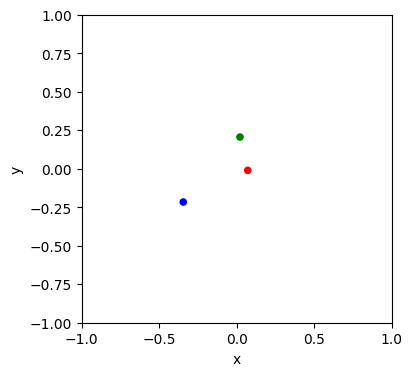

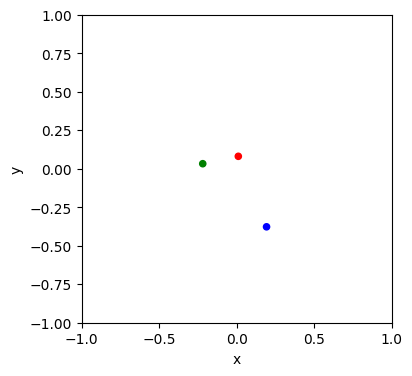

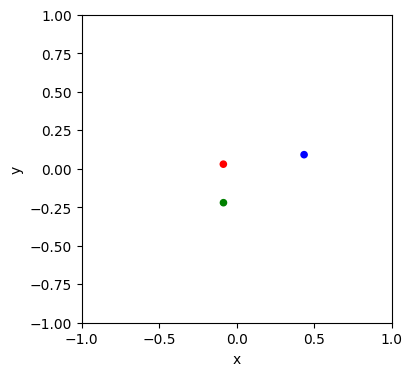

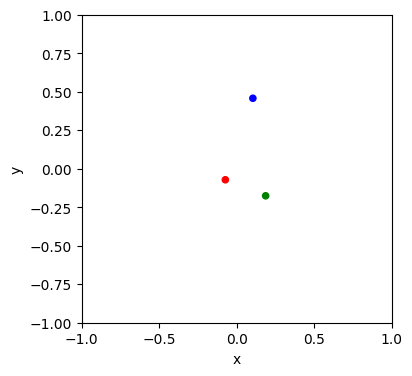

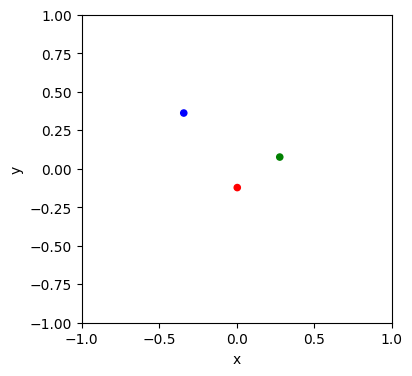

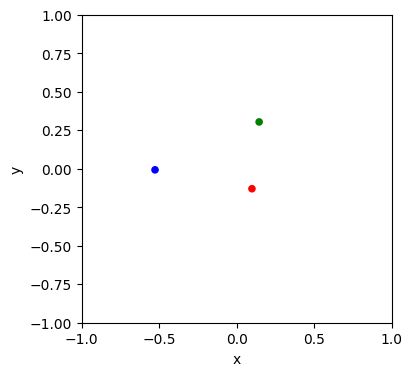

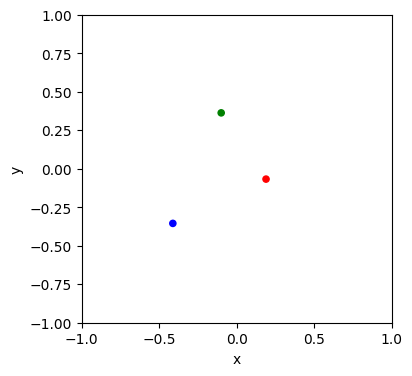

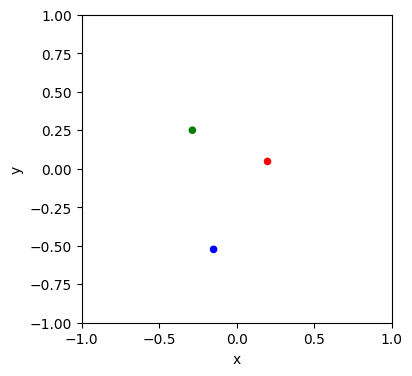

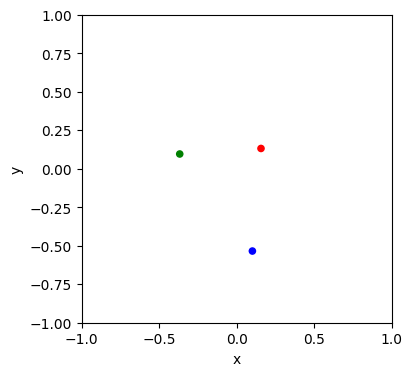

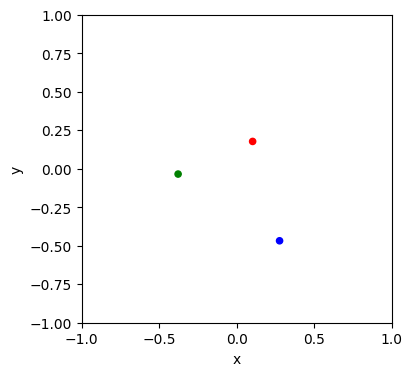

In [19]:
plotkw = {
    'color': list('rgb'),
    'figsize': (4,4),
    'x': 'x',
    'xlim': (-1,1),
    'y': 'y',
    'ylim': (-1,1)
}

for t, frame in enumerate(graph(128)):
    if not (t % 8):
        frame.plot.scatter(**plotkw)

## help

In [20]:
help(GraphFrame)

Help on class GraphFrame in module graph:

class GraphFrame(builtins.object)
 |  GraphFrame(links)
 |  
 |  Store graph data and calculate coordinates for drawing that graph.
 |  Uses drawing physics based on based on Gephi's ForceAtlas2 energy model.
 |  
 |  Inputs:
 |      DataFrame with [source, target] as first 2 columns, OR
 |      DataFrame with [source, target, weight] as first 3 columns, OR
 |      anything accepted by pandas.DataFrame() constructor
 |  
 |  If no weight is provided, links are weighted by how often they appear.
 |  
 |  Call with a number of timesteps to return two NumPy arrays (x, y).
 |  Call accepts optional starting coordinates as 'x', 'y' keyword arguments.
 |  Coordinates are typically, but not always, in the range [-1, 1].
 |  
 |  Methods defined here:
 |  
 |  __call__(self, nsteps)
 |      Call self as a function.
 |  
 |  __init__(self, links)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __iter__(self)
 |  
 |  __l